# Exciton wave functions from the multiband model

### References
[1] M. Van der Donck, M. Zarenia, and F. M. Peeters, Phys. Rev. B 96, 035131 (2017).

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg
from scipy import special
from scipy.integrate import quad
from matplotlib import cm
%matplotlib inline

In [160]:
### Constants and parameters of the model
e0=1.6e-19 # Coulomb
eps0=8.854e-12 # F/m
eps1=1.0 # top: vacuum
eps2=3.9 # bottom: SiO2 substrate,from Ref.[1]
kappa=0.5*(eps1+eps2)
a0=3.193 # lattice constant for MoS2 from Ref.[1], in Angstrom 
r0=41.47/a0 # screening length for MoS2 from Ref.[1], in normalized units
lam=0.15/2. # in eV for MoS2 from Ref.[1]
Delta=1.66 # in eV for MoS2 from Ref.[1]
thop=1.10 # hopping parameter t in eV
se=1; te=1; sh=-1; th=-1; # A-exciton in K valley

In [161]:
### My definitions, in units of thop
De=(Delta-se*te*lam)/thop; 
Dh=(Delta-sh*th*lam)/thop; 
Lambda=lam*(sete-shth)/thop;
Vfactor=e0/(4.*np.pi*kappa*eps0*a0*1.e-10)/thop # dimensionless factor

In [162]:
### Keldysh potential: Fig.1 of Van der Donck et al. (they use kappa=1 there)
# plt.rc('font', size=14)
# fig,ax = plt.subplots()
# plt.suptitle('Keldysh potential')
# ax.set_xlim([0,100])
# ax.set_ylim([-1.2,0.])
# ax.set_xlabel(r'$r$, Angstrom')
# ax.set_ylabel(r'$-V(r/a_0)$, eV')
# rinA = np.linspace(0.001,100,200) # in A
# def VKeldysh(r,r0): # r, r0: in units a0
#     return Vfactor*np.pi/(2.*r0)*(special.struve(0,r/r0)-special.y0(r/r0)) # in units thop
# ax.plot(rinA,-thop*VKeldysh(rinA/a0,60./a0),'k',ls='dotted',lw=2,label=r'$r_0=60\rm\,A$')
# ax.plot(rinA,-thop*VKeldysh(rinA/a0,20./a0),'r',ls='dashed',lw=2,label=r'$r_0=20\rm\,A$')
# ax.plot(rinA,-thop*VKeldysh(rinA/a0,0.01/a0),'b',ls='solid',lw=2,label=r'$r_0=0.01\rm\,A$')
# ax.legend();

# Numerical calculation

In [163]:
### Discretization
kmax=0.4; dk=0.004; M=int(kmax/dk);
krange=dk*np.arange(1,M+1);
M

100

$$
\tilde{V}_{0}(k,k') = \mathcal{V}_0\,\frac{1}{\pi} \int_0^\pi  \frac{1}{q(1+r_0 q)}\, d\varphi.
$$

In [164]:
def V0integrand(phi,k1,k2):
    q=np.sqrt(k1*k1+k2*k2-2.*k1*k2*np.cos(phi))
    return 1./(q*(1.+r0*q))

def V0(k1,k2):
    assert k1!=k2
    return (Vfactor/np.pi)*quad(V0integrand,0.,np.pi,args=(k1,k2),limit=200)[0]

$$
\tilde{V}_{0}(k,k') = \frac{\mathcal{V}_0}{\pi} \int_0^\pi \frac{1}{q}\,d\varphi
-
\frac{\mathcal{V}_0}{\pi} \int_0^\pi  \frac{r_0}{1+r_0q} \, d\varphi
$$
$$
w_{0,nn}=\frac{1}{k_n}\int_{k_n-\frac12\Delta k}^{k_n+\frac12\Delta k}
\tilde{V}_0^{\rm (sing)}(k_n,k')\, k' \,dk' 
+ \tilde{V}_0^{\rm (nonsing)}(k_n,k_n) \, \Delta k
$$

In [165]:
def V0sing_undefined_k2integral(k1,k2):
    ellarg = -4.*k1*k2/(k1-k2)**2
    return Vfactor*(np.abs(k1-k2)*special.ellipe(ellarg) - np.sign(k1-k2)*(k1+k2)*special.ellipk(ellarg))

def V0nonsing_integrand(phi,k):
    q=k*np.sqrt(2.-2.*np.cos(phi))
    return r0/(1.+r0*q)

def V0nonsing(k):
    return -(Vfactor/np.pi)*quad(V0nonsing_integrand,0.,np.pi,args=(k,),limit=200)[0]

def w0nn(k):
    w0sing = (1./np.pi)*(V0sing_undefined_k2integral(k,k+0.5*dk)-V0sing_undefined_k2integral(k,k-0.5*dk))/k
    w0nonsing = V0nonsing(k)*dk
    return w0sing + w0nonsing

def w0(n,m):
    if(n==m):
        return w0nn(krange[n])
    else:
        return V0(krange[n],krange[m]) * dk

np_w0=np.vectorize(w0)

$$
\tilde{V}_{1}(k,k') = \mathcal{V}_0\,\frac{kk'}{\pi}     \int_0^\pi 
\frac{1+2r_0q}{q^3(1+r_0q)^2}\, \sin^2\varphi\; d\varphi
$$

In [166]:
def V1integrand(phi,k1,k2):
    q=np.sqrt(k1*k1+k2*k2-2.*k1*k2*np.cos(phi))
    return (1.+2*r0*q)/(q**3*(1.+r0*q)**2)*np.sin(phi)**2

def V1(k1,k2):
    assert k1!=k2
    return Vfactor*(k1*k2/np.pi)*quad(V1integrand,0.,np.pi,args=(k1,k2),limit=200)[0]

$$
\tilde{V}_{1}(k,k') = \mathcal{V}_0\,\frac{kk'}{\pi} \int_0^\pi \left( \frac{1}{q^3} - \frac{r_0^2}{q}\right)\sin^2\varphi\,d\varphi
+
\mathcal{V}_0\,\frac{kk'}{\pi} \int_0^\pi  \frac{r_0^3 \left(2+r_0q\right)}{\left(1+r_0q\right)^2} \sin^2\varphi\, d\varphi.
$$
$$
w_{1,nn}=\frac{1}{k_n}\int_{k_n-\frac12\Delta k}^{k_n+\frac12\Delta k}
\tilde{V}_1^{\rm (sing)}(k_n,k')\, k' \,dk' 
+ \tilde{V}_1^{\rm (nonsing)}(k_n,k_n) \, \Delta k
$$

In [167]:
def V1sing_undefined_k2integral(k1,k2):
    ellarg = -4.*k1*k2/(k1-k2)**2
    efactor=r0*r0*(7.*k1*k1+k2*k2)+9.
    kfactor=(k1+k2)*(r0*r0*(k1-k2)*(k1+k2)-9.)
    return Vfactor*(-np.abs(k1-k2)*efactor*special.ellipe(ellarg) + np.sign(k1-k2)*kfactor*special.ellipk(ellarg))/(9.*k1*k1)

def V1nonsing_integrand(phi,k):
    q=k*np.sqrt(2.-2.*np.cos(phi))
    return np.sin(phi)**2*(2.+r0*q)/(1.+r0*q)**2

def V1nonsing(k):
    return Vfactor*(k*k*r0*r0*r0/np.pi)*quad(V0nonsing_integrand,0.,np.pi,args=(k,),limit=200)[0]

def w1nn(k):
    w1sing = (k/np.pi)*(V1sing_undefined_k2integral(k,k+0.5*dk)-V1sing_undefined_k2integral(k,k-0.5*dk))
    w1nonsing = V1nonsing(k)*dk
    return w1sing + w1nonsing

def w1(n,m):
    if(n==m):
        return w1nn(krange[n])
    else:
        return V1(krange[n],krange[m]) * dk 
    
np_w1=np.vectorize(w1)    

In [168]:
nn,mm = np.meshgrid(np.arange(M),np.arange(M),indexing='xy')
trinds = np.tril_indices(M) # lower triagle indices
dinds = np.diag_indices(M) # diagonal indices

In [169]:
w0data = np.zeros((M,M))
%time w0data[trinds]=np_w0(*trinds) # operator * expands tuple into arguments

CPU times: user 1.04 s, sys: 0 ns, total: 1.04 s
Wall time: 1.04 s


In [170]:
w1data = np.zeros((M,M))
%time w1data[trinds]=np_w1(*trinds)

CPU times: user 2.39 s, sys: 0 ns, total: 2.39 s
Wall time: 2.39 s


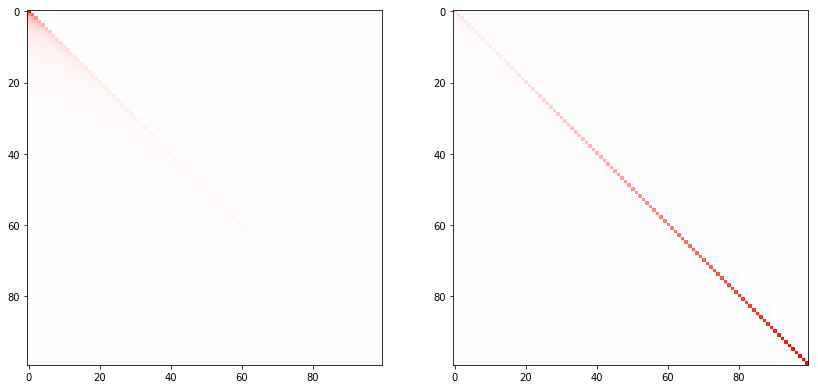

In [171]:
fig,ax=plt.subplots(1,2,figsize=(14,14))
w0max=np.max(np.abs(w0data))
w1max=np.max(np.abs(w1data))
ax[0].imshow(w0data,cmap=cm.bwr, vmin=-w0max, vmax=w0max)
ax[1].imshow(w1data,cmap=cm.bwr, vmin=-w1max, vmax=w1max)

In [172]:
Amatrix=np.zeros((4*M,4*M),dtype=np.complex128)

In [173]:
Amatrix[0:M,0:M][trinds]=-w1data[trinds]
Amatrix[M:2*M,M:2*M][trinds]=-w0data[trinds]
Amatrix[2*M:3*M,2*M:3*M][trinds]=-w0data[trinds]
Amatrix[3*M:4*M,3*M:4*M][trinds]=-w1data[trinds]

In [174]:
Amatrix[M:2*M,M:2*M][dinds] += Dh/krange
Amatrix[2*M:3*M,2*M:3*M][dinds] -= De/krange

In [175]:
Amatrix[M:2*M,0:M][dinds] = -1j*np.ones(M)
Amatrix[2*M:3*M,0:M][dinds] = -1j*np.ones(M)
Amatrix[3*M:4*M,M:2*M][dinds] = 1j*np.ones(M)
Amatrix[3*M:4*M,2*M:3*M][dinds] = 1j*np.ones(M)

In [176]:
### Upper triangle of Amatrix (optional)
# Amatrix[0:M,M:2*M][dinds] = 1j*np.ones(M)
# Amatrix[0:M,2*M:3*M][dinds] = 1j*np.ones(M)
# Amatrix[M:2*M,3*M:4*M][dinds] = -1j*np.ones(M)
# Amatrix[2*M:3*M,3*M:4*M][dinds] = -1j*np.ones(M)

In [177]:
### Check: sparsity pattern of Amatrix
# fig,ax=plt.subplots(1,2,figsize=(14,14))
# ax[0].imshow(Amatrix.real,cmap=cm.bwr)
# ax[1].imshow(Amatrix.imag,cmap=cm.bwr)

In [178]:
Kmatrix=np.diag(np.concatenate((krange,krange,krange,krange)))

In [179]:
### Check: evaluation of the matrix Ksq@Amatrix@Ksq
# Ksq=np.sqrt(Kmatrix)
# np.set_printoptions(precision=3)
# (Ksq@Amatrix@Ksq)

In [180]:
%time evalsunsorted,Tevecs=linalg.eigh(Amatrix,b=Kmatrix,type=2,lower=True)
evecsunsorted=Tevecs.T
inds=np.argsort(evalsunsorted)
evals=evalsunsorted[inds]
evecs=evecsunsorted[inds]

CPU times: user 161 ms, sys: 0 ns, total: 161 ms
Wall time: 91.4 ms


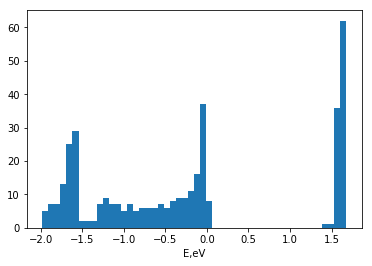

In [181]:
fig,ax=plt.subplots()
inds=np.where(((evals*thop>-2)&(evals*thop<2)))
ax.hist(thop*evals[inds],bins=50)
ax.set_xlabel('E,eV')
plt.show()

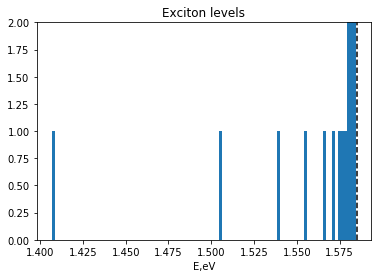

Lowest 3 exciton levels (in eV): [1.40679845 1.50604818 1.53981363]
Dh (in eV): 1.585


In [182]:
inds=np.where(((thop*evals>0) & (thop*evals<thop*Dh)))
ex0ind=inds[0][0]
fig,ax=plt.subplots()
ax.set_title('Exciton levels')
ax.hist(thop*evals[inds],bins=100)
ax.axvline(x=thop*Dh,ls='dashed',c='k')
ax.set_xlabel('E,eV')
ax.set_ylim([0,2])
plt.show()
print('Lowest 3 exciton levels (in eV):',thop*evals[ex0ind+np.arange(3)])
print('Dh (in eV):',Dh*thop)

In [183]:
def psi1(r,nv):
    return np.sum(evecs[nv,0:M][:,None]*special.j1(krange[:,None]*r)*krange[:,None]*dk,axis=0)

def rho1(r,nv):
    psi=psi1(r,nv)
    return (psi*np.conjugate(psi)).real

def psi2(r,nv):
    return np.sum(evecs[nv,M:2*M][:,None]*special.j0(krange[:,None]*r)*krange[:,None]*dk,axis=0)

def rho2(r,nv):
    psi=psi2(r,nv)
    return (psi*np.conjugate(psi)).real

def psi3(r,nv):
    return np.sum(evecs[nv,2*M:3*M][:,None]*special.j0(krange[:,None]*r)*krange[:,None]*dk,axis=0)

def rho3(r,nv):
    psi=psi3(r,nv)
    return (psi*np.conjugate(psi)).real

def psi4(r,nv):
    return np.sum(evecs[nv,3*M:4*M][:,None]*special.j1(krange[:,None]*r)*krange[:,None]*dk,axis=0)

def rho4(r,nv):
    psi=psi4(r,nv)
    return (psi*np.conjugate(psi)).real

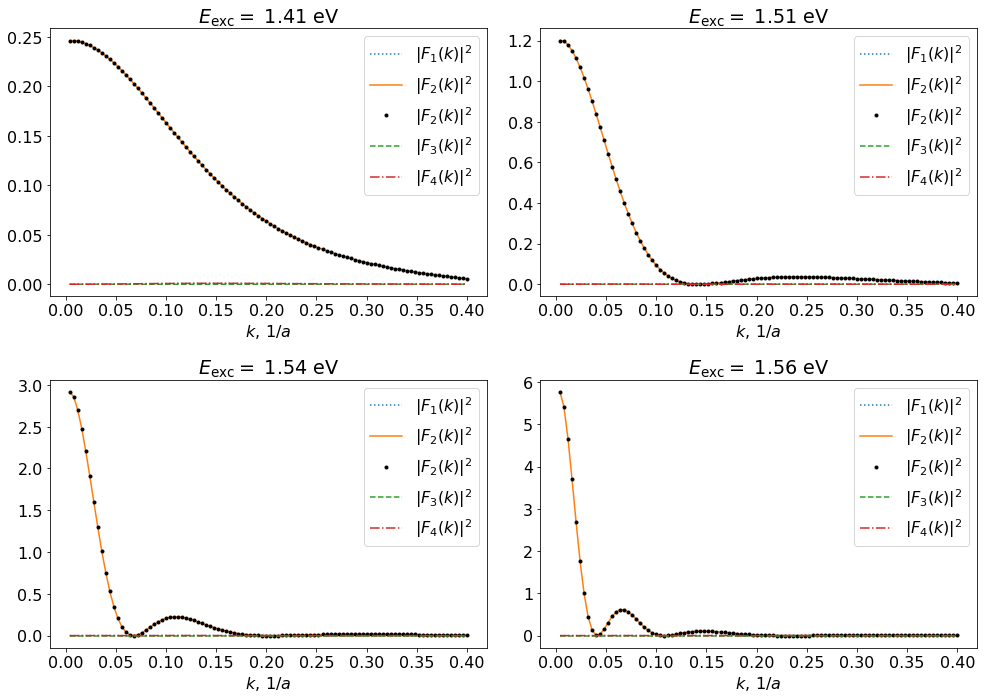

In [184]:
plt.rc('font', size=16)
fig,ax=plt.subplots(2,2,figsize=(14,10))
lw=1.5; alpha=1;

for (i,nv) in [[(0,0),ex0ind],[(0,1),ex0ind+1],[(1,0),ex0ind+2],[(1,1),ex0ind+3]]:
    ax[i].plot(krange,np.abs(evecs[nv,0:M])**2,ls='dotted',label=r'$|F_1(k)|^2$',lw=lw,alpha=alpha)
    ax[i].plot(krange,np.abs(evecs[nv,M:2*M])**2,ls='solid',label=r'$|F_2(k)|^2$',lw=lw,alpha=alpha)
    ax[i].plot(krange,np.abs(evecs[nv,M:2*M])**2,'k.',label=r'$|F_2(k)|^2$',lw=lw,alpha=alpha)        
    ax[i].plot(krange,np.abs(evecs[nv,2*M:3*M])**2,ls='dashed',label=r'$|F_3(k)|^2$',lw=lw,alpha=alpha)
    ax[i].plot(krange,np.abs(evecs[nv,3*M:4*M])**2,ls='dashdot',label=r'$|F_4(k)|^2$',lw=lw,alpha=alpha)
    ax[i].set_xlabel(r'$k,\,1/a$')
    ax[i].set_title(r'$E_{\rm exc}=$ %.2f eV' % (thop*evals[nv]))
    ax[i].legend()
#    ax[i].set_xlim([0.,krange[-1]])
plt.tight_layout()

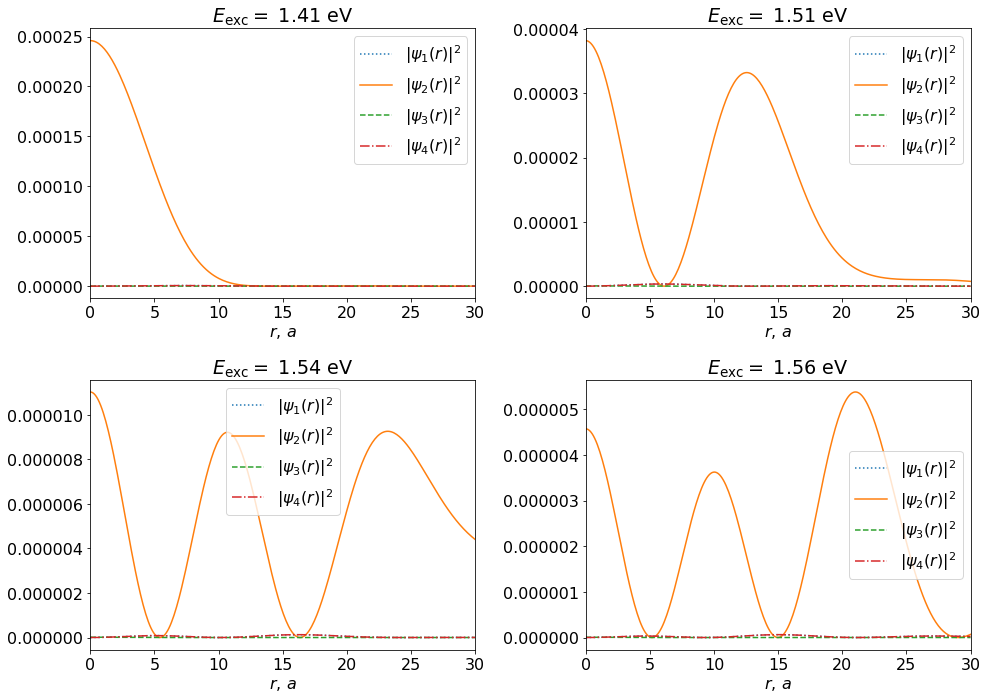

In [185]:
plt.rc('font', size=16)
fig,ax=plt.subplots(2,2,figsize=(14,10))
rmax=30.; lw=1.5; alpha=1;
rrange=np.linspace(0.,rmax,300)

for (i,nv) in [[(0,0),ex0ind],[(0,1),ex0ind+1],[(1,0),ex0ind+2],[(1,1),ex0ind+3]]:
    ax[i].plot(rrange,rho1(rrange,nv),ls='dotted',label=r'$|\psi_1(r)|^2$',lw=lw,alpha=alpha)
    ax[i].plot(rrange,rho2(rrange,nv),ls='solid',label=r'$|\psi_2(r)|^2$',lw=lw,alpha=alpha)
    ax[i].plot(rrange,rho3(rrange,nv),ls='dashed',label=r'$|\psi_3(r)|^2$',lw=lw,alpha=alpha)
    ax[i].plot(rrange,rho4(rrange,nv),ls='dashdot',label=r'$|\psi_4(r)|^2$',lw=lw,alpha=alpha)
    ax[i].set_xlabel(r'$r,\,a$')
    ax[i].set_title(r'$E_{\rm exc}=$ %.2f eV' % (thop*evals[nv]))    
    ax[i].legend()
    ax[i].set_xlim([0.,rmax])   
plt.tight_layout()